<a href="https://colab.research.google.com/github/trick491/Data-Science-Final-Project/blob/main/milestone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring the Relationship Between Financial Statement Items and Stock Performance**

Patrick Johnson and Anh Pham

##**Project Goals**

The goal of this project is to analyze and determine how different financial statement indexes correlate with stock price changes for companies in the S&P 500 over the past ten years. Instead of focusing on the most common measure, earnings per share (EPS), we want to see if factors like depreciation, assets, or liabilities also help explain stock performance. By finding these correlations, we hope to better understand how financial decisions and company internal set up are reflected in investor behavior and market value.
<br><br>

##**Project Dataset**

The datasets we are considering working with are the SEC EDGAR Financial Statement Metrics and Yahoo Finance Historical Stock Data. Together, these two datasets will allow us to examine how companies’ internal financial structures influence their external market performance over time. Our goal is to identify relationships between balance sheet and income statement items, especially those unrelated to earnings per share (EPS) (such as depreciation and total liabilities), and stock price trends for firms in the S&P 500 index.
<br><br>
The SEC EDGAR dataset provides standardized financial statement information of publicly traded U.S. companies, including variables like total assets, total liabilities, depreciation, and operating income. The Yahoo Finance dataset contains corresponding market data such as daily closing prices and trading volumes. By organizing the stock data by year and linking it to the financial data from EDGAR using company tickers or IDs, we can create one dataset that shows both a company’s financial performance and its market value
<br><br>
This integration will allow us to answer questions such as: How do changes in liabilities or depreciation expenses relate to changes in stock prices? Do firms with more asset growth correlate to higher long-term stock performance? Combining these two datasets bridges the gap between corporate accounting and investor behavior, providing a comprehensive foundation for analyzing how internal financial indicators translate into market outcomes.
<br><br>

##**Collaboration Plan**
Our collaboration plan is to divide tasks and work individually on google colab, while actively communicating via message. We will meet up in person once a week to update our progress, finalize our project vision, discuss the quality of our work, and resolve any issues. We have also set up a shared GitHub repository to coordinate our work and upload code. All code contributions are documented with clear comments and commit messages. One member will focus on data extraction and cleaning (ETL from EDGAR and Yahoo Finance). The other will handle data analysis and visualization, ensuring results are clearly communicated on our GitHub Pages website. We will focus on our task but also actively assist the other person when needed.  



**Pull Together Data**

In [1]:
import pandas as pd
import requests
from io import StringIO

edgar_api = 'https://api.github.com/repos/trick491/Data-Science-Final-Project/contents/data/edgar'
yahoo_api = 'https://api.github.com/repos/trick491/Data-Science-Final-Project/contents/data/yahoo'

edgar_response = requests.get(edgar_api)
yahoo_response = requests.get(yahoo_api)

edgar_df = pd.DataFrame()
yahoo_df = pd.DataFrame()

if edgar_response.status_code == 200:
    edgar_files = edgar_response.json()
    for file in edgar_files:
        if file['name'].endswith('.csv'):
            file_url = file['download_url']
            df_temp = pd.read_csv(file_url)
            edgar_df = pd.concat([edgar_df, df_temp], ignore_index=True)
            print(f"Loaded EDGAR file: {file['name']}")

if yahoo_response.status_code == 200:
    yahoo_files = yahoo_response.json()
    for file in yahoo_files:
        if file['name'].endswith('.csv'):
            file_url = file['download_url']
            df_temp = pd.read_csv(file_url)
            yahoo_df = pd.concat([yahoo_df, df_temp], ignore_index=True)
            print(f"Loaded Yahoo file: {file['name']}")

print(f"\nEDGAR DataFrame shape: {edgar_df.shape}")
print(f"Yahoo DataFrame shape: {yahoo_df.shape}")

Loaded EDGAR file: edgar_1.csv
Loaded EDGAR file: edgar_10.csv
Loaded EDGAR file: edgar_11.csv
Loaded EDGAR file: edgar_12.csv
Loaded EDGAR file: edgar_13.csv
Loaded EDGAR file: edgar_14.csv
Loaded EDGAR file: edgar_15.csv
Loaded EDGAR file: edgar_16.csv
Loaded EDGAR file: edgar_17.csv
Loaded EDGAR file: edgar_18.csv
Loaded EDGAR file: edgar_19.csv
Loaded EDGAR file: edgar_2.csv
Loaded EDGAR file: edgar_20.csv
Loaded EDGAR file: edgar_21.csv
Loaded EDGAR file: edgar_22.csv
Loaded EDGAR file: edgar_23.csv
Loaded EDGAR file: edgar_24.csv
Loaded EDGAR file: edgar_25.csv
Loaded EDGAR file: edgar_26.csv
Loaded EDGAR file: edgar_27.csv
Loaded EDGAR file: edgar_28.csv
Loaded EDGAR file: edgar_29.csv
Loaded EDGAR file: edgar_3.csv
Loaded EDGAR file: edgar_30.csv
Loaded EDGAR file: edgar_31.csv
Loaded EDGAR file: edgar_32.csv
Loaded EDGAR file: edgar_33.csv
Loaded EDGAR file: edgar_34.csv
Loaded EDGAR file: edgar_35.csv
Loaded EDGAR file: edgar_36.csv
Loaded EDGAR file: edgar_37.csv
Loaded EDGA

Now we will create two rows with price before and after quarterlies

In [2]:
from multiprocessing import Pool, cpu_count
import numpy as np
from tqdm import tqdm

# FILTER BY TICKER: Set to None for all stocks, or specify ticker like 'GOOG'
FILTER_TICKER = 'GOOG'  # Default: process all tickers. Change to 'GOOG', 'AAPL', etc. to isolate one stock

print(edgar_df.head())
print(yahoo_df.head())

# Filter data if ticker is specified BEFORE copying
if FILTER_TICKER is not None:
    print(f"\n*** FILTERING DATA FOR TICKER: {FILTER_TICKER} ***\n")
    full_data = edgar_df[edgar_df['Ticker'] == FILTER_TICKER].copy()
    yahoo_df_filtered = yahoo_df[yahoo_df['Ticker'] == FILTER_TICKER].copy()
    print(f"Filtered to {len(full_data)} edgar rows and {len(yahoo_df_filtered)} yahoo rows for {FILTER_TICKER}")
else:
    print(f"\n*** PROCESSING ALL TICKERS ***\n")
    full_data = edgar_df.copy()
    yahoo_df_filtered = yahoo_df.copy()
    print(f"Total edgar rows: {len(full_data)}, Total yahoo rows: {len(yahoo_df_filtered)}")

# Create a dictionary for faster lookups (only for filtered tickers)
print("Creating lookup dictionary...")
yahoo_dict = {}
for ticker in tqdm(yahoo_df_filtered['Ticker'].unique(), desc="Processing tickers"):
    ticker_data = yahoo_df_filtered[yahoo_df_filtered['Ticker'] == ticker].sort_values('Date')
    yahoo_dict[ticker] = ticker_data

def get_price_before(args):
    idx, ticker, filed_date = args

    if ticker not in yahoo_dict:
        return None

    ticker_data = yahoo_dict[ticker]
    matching = ticker_data[ticker_data['Date'] <= filed_date]
    return matching.iloc[-1]['Close'] if len(matching) > 0 else None

def get_price_after(args):
    idx, ticker, filed_date = args

    if ticker not in yahoo_dict:
        return None

    ticker_data = yahoo_dict[ticker]
    matching = ticker_data[ticker_data['Date'] > filed_date]
    return matching.iloc[0]['Close'] if len(matching) > 0 else None

# Prepare arguments for parallel processing
print("Preparing data...")
args_list = [(idx, row.Ticker, row.Filed) for idx, row in enumerate(full_data.itertuples())]

# Calculate Price before in parallel
num_cores = cpu_count()
print(f"\nUsing {num_cores} cores")
print("Calculating 'Price before' in parallel...")

with Pool(num_cores) as pool:
    results = list(tqdm(
        pool.imap(get_price_before, args_list, chunksize=1000),
        total=len(args_list),
        desc="Price before"
    ))
    full_data['Price before'] = results

print("✓ 'Price before' complete!\n")

# Calculate Price after in parallel
print("Calculating 'Price after' in parallel...")

with Pool(num_cores) as pool:
    results = list(tqdm(
        pool.imap(get_price_after, args_list, chunksize=1000),
        total=len(args_list),
        desc="Price after"
    ))
    full_data['Price after'] = results

print("✓ 'Price after' complete!\n")

print('****************** AFTER TRANSFORMATION ********************')

print(full_data.head())

  Ticker      CIK                      Label                   Title  \
0   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   
1   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   
2   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   
3   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   
4   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   

                                         Description Unit         Value  \
0  Carrying value as of the balance sheet date of...  USD  6.037000e+09   
1  Carrying value as of the balance sheet date of...  USD  6.037000e+09   
2  Carrying value as of the balance sheet date of...  USD  6.037000e+09   
3  Carrying value as of the balance sheet date of...  USD  6.037000e+09   
4  Carrying value as of the balance sheet date of...  USD  6.037000e+09   

         Date       Filed  Fiscal Year Fiscal Period  Form  
0  2021-12-31  2022-02-02       2021.0            FY  1

Processing tickers: 100%|██████████| 1/1 [00:00<00:00, 175.21it/s]

Preparing data...

Using 2 cores
Calculating 'Price before' in parallel...



Price before: 100%|██████████| 6129/6129 [00:05<00:00, 1101.95it/s]

✓ 'Price before' complete!

Calculating 'Price after' in parallel...



Price after: 100%|██████████| 6129/6129 [00:04<00:00, 1252.72it/s]


✓ 'Price after' complete!

****************** AFTER TRANSFORMATION ********************
  Ticker      CIK                      Label                   Title  \
0   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   
1   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   
2   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   
3   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   
4   GOOG  1652044  Accounts Payable, Current  AccountsPayableCurrent   

                                         Description Unit         Value  \
0  Carrying value as of the balance sheet date of...  USD  6.037000e+09   
1  Carrying value as of the balance sheet date of...  USD  6.037000e+09   
2  Carrying value as of the balance sheet date of...  USD  6.037000e+09   
3  Carrying value as of the balance sheet date of...  USD  6.037000e+09   
4  Carrying value as of the balance sheet date of...  USD  6.037000e+09   

         Date       Filed  F

Implement metric changes quarter / quarter absolute value change and % change

In [3]:
from multiprocessing import Pool, cpu_count
import pandas as pd
import numpy as np
from tqdm import tqdm

# Calculate quarter-over-quarter changes
print("Calculating quarter-over-quarter changes...")

# Remove any existing QoQ columns before recalculating
existing_qoq_cols = [col for col in full_data.columns if 'QoQ' in col or 'Previous' in col]
if existing_qoq_cols:
    print(f"Removing {len(existing_qoq_cols)} existing QoQ columns: {existing_qoq_cols}")
    full_data = full_data.drop(columns=existing_qoq_cols)

# Sort by Ticker and Date to ensure proper ordering
full_data = full_data.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Calculate previous quarter values and changes
print("Calculating previous quarter values and changes...")

# Initialize new columns
full_data['Price before Previous'] = np.nan
full_data['Price after Previous'] = np.nan
full_data['Value Previous'] = np.nan
full_data['Price Change %'] = np.nan
full_data['Value QoQ Change %'] = np.nan
full_data['Value QoQ Abs Change'] = np.nan

# Calculate row by row
for idx in range(1, len(full_data)):
    current_row = full_data.iloc[idx]
    previous_row = full_data.iloc[idx - 1]

    # Check if same ticker AND same account label
    if (current_row['Ticker'] == previous_row['Ticker'] and
        current_row['Label'] == previous_row['Label']):

        # Store previous quarter values
        full_data.loc[idx, 'Price before Previous'] = previous_row['Price before']
        full_data.loc[idx, 'Price after Previous'] = previous_row['Price after']
        full_data.loc[idx, 'Value Previous'] = previous_row['Value']

        # Calculate Price Change % (Price after vs Price before, current quarter)
        if pd.notna(current_row['Price before']) and pd.notna(current_row['Price after']) and current_row['Price before'] != 0:
            full_data.loc[idx, 'Price Change %'] = ((current_row['Price after'] - current_row['Price before']) / current_row['Price before']) * 100

        # Calculate Value QoQ Change %
        if pd.notna(current_row['Value']) and pd.notna(previous_row['Value']) and previous_row['Value'] != 0:
            full_data.loc[idx, 'Value QoQ Change %'] = ((current_row['Value'] - previous_row['Value']) / previous_row['Value']) * 100

        # Calculate Value QoQ Abs Change
        if pd.notna(current_row['Value']) and pd.notna(previous_row['Value']):
            full_data.loc[idx, 'Value QoQ Abs Change'] = current_row['Value'] - previous_row['Value']

print("✓ Quarter-over-quarter changes calculated!\n")

print('****************** WITH QoQ CHANGES ********************')

# Display comprehensive summary
print("\n****************** COMPLETE QoQ CHANGES SUMMARY ********************")
summary_cols = [
    'Ticker', 'Date', 'Filed', 'Fiscal Period', 'Label',
    'Price before', 'Price after', 'Price Change %',
    'Value Previous', 'Value', 'Value QoQ Abs Change', 'Value QoQ Change %'
]
summary_sample = full_data[summary_cols].head(20)
print(summary_sample)

# Show statistics on NaN values
print("\n****************** NaN STATISTICS ********************")
for col in ['Price Change %', 'Value QoQ Change %', 'Value QoQ Abs Change']:
    nan_count = full_data[col].isna().sum()
    total_count = len(full_data)
    pct_nan = (nan_count / total_count) * 100
    print(f"{col}: {nan_count}/{total_count} NaN values ({pct_nan:.1f}%)")

Calculating quarter-over-quarter changes...
Calculating previous quarter values and changes...
✓ Quarter-over-quarter changes calculated!

****************** WITH QoQ CHANGES ********************

****************** COMPLETE QoQ CHANGES SUMMARY ********************
   Ticker        Date       Filed Fiscal Period  \
0    GOOG  2021-12-31  2022-02-02            FY   
1    GOOG  2021-12-31  2022-04-27            Q1   
2    GOOG  2021-12-31  2022-07-27            Q2   
3    GOOG  2021-12-31  2022-10-26            Q3   
4    GOOG  2021-12-31  2023-02-03            FY   
5    GOOG  2021-12-31  2022-02-02            FY   
6    GOOG  2021-12-31  2022-04-27            Q1   
7    GOOG  2021-12-31  2022-07-27            Q2   
8    GOOG  2021-12-31  2022-10-26            Q3   
9    GOOG  2021-12-31  2023-02-03            FY   
10   GOOG  2021-12-31  2022-02-02            FY   
11   GOOG  2021-12-31  2022-04-27            Q1   
12   GOOG  2021-12-31  2022-07-27            Q2   
13   GOOG  2021-12-3

Example of relation, normalized, between Net Income (Loss) Attributable to Parent and price before and after

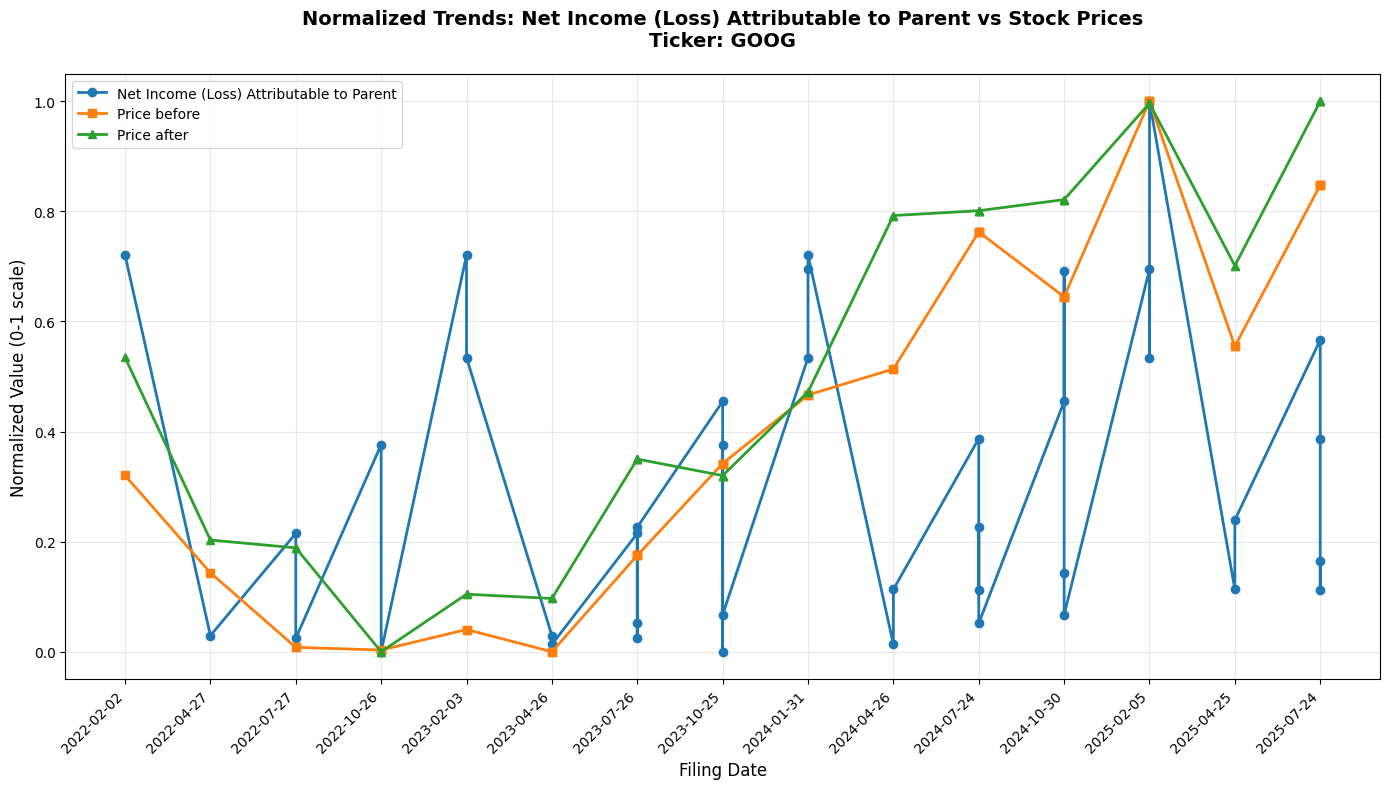

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define variables to plot
y1 = 'Net Income (Loss) Attributable to Parent'
y2 = 'Price before'
y3 = 'Price after'

# Filter data for the specific label
plot_data = full_data[full_data['Label'] == y1].copy()

# Sort by Filed date
plot_data = plot_data.sort_values('Filed')

# Normalize all three variables to 0-1 scale
scaler = MinMaxScaler()
plot_data['Value_norm'] = scaler.fit_transform(plot_data[['Value']])
plot_data['Price_before_norm'] = scaler.fit_transform(plot_data[['Price before']])
plot_data['Price_after_norm'] = scaler.fit_transform(plot_data[['Price after']])

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot all three normalized variables
ax.plot(plot_data['Filed'], plot_data['Value_norm'], color='tab:blue', marker='o', linewidth=2, markersize=6, label=y1)
ax.plot(plot_data['Filed'], plot_data['Price_before_norm'], color='tab:orange', marker='s', linewidth=2, markersize=6, label='Price before')
ax.plot(plot_data['Filed'], plot_data['Price_after_norm'], color='tab:green', marker='^', linewidth=2, markersize=6, label='Price after')

# Labels and title
ax.set_xlabel('Filing Date', fontsize=12)
ax.set_ylabel('Normalized Value (0-1 scale)', fontsize=12)
ax.set_title(f'Normalized Trends: {y1} vs Stock Prices\nTicker: {FILTER_TICKER}', fontsize=14, fontweight='bold', pad=20)

# Grid and legend
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Tight layout
fig.tight_layout()

plt.show()




***